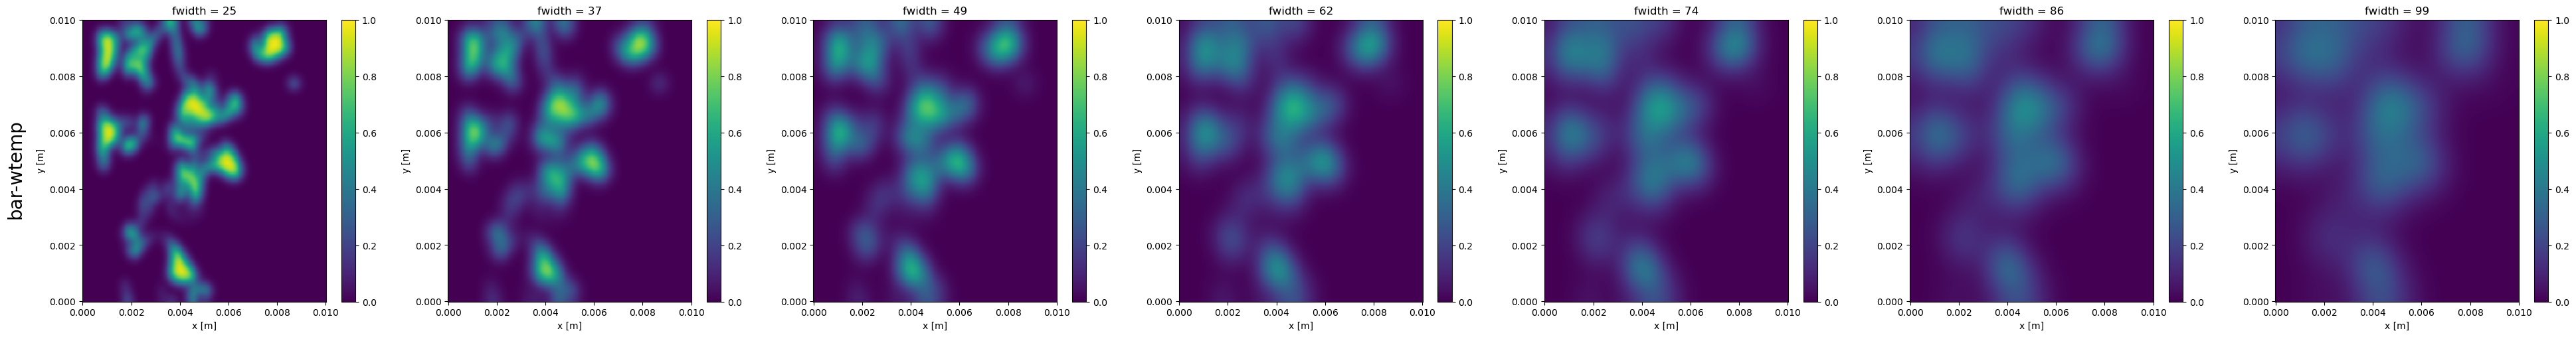

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from gauss import gaus

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)
x = np.arange(0, lx + dx, dx)
y = np.arange(0, ly + dy, dy)



def phi_res(w_temp, nabla_cT):
    binary_mask  = ((w_temp > 0.4) & (nabla_cT < 0.2)).astype(float)
    return binary_mask

#
# flame related constants
fwidth_n = np.array([25, 37, 49, 62, 74, 86, 99])

# Create figure and subplots
plt.figure(figsize=(40, 5))

#print(np.count_nonzero(phi_res(load_w_bar(49), load_nabla_cT(49))))

for i, fwidth in enumerate(fwidth_n):
    # Load the pre-filtered data
    w_bar = np.fromfile('rest_of_the_data\case_B1_slice_data\wtemp-slice-B1-0000080000.raw', count=-1, dtype=np.float64).reshape(nx, ny)
    w_bar[:27,:] = 0
    w_bar[346:,:] = 0
    global_min, global_max = np.min(w_bar), np.max(w_bar)
    w_bar = (w_bar-global_min)/(global_max-global_min)

    nabla_ct = np.fromfile('rest_of_the_data/case_B1_slice_data/nablatemp-slice-B1-0000080000.raw', count=-1, dtype=np.float64).reshape(nx, ny)
    nabla_ct[:27,:] = 0
    nabla_ct[346:,:] = 0
    global_min, global_max = np.min(nabla_ct), np.max(nabla_ct)
    nabla_ct = (nabla_ct-global_min)/(global_max-global_min)


    phi = phi_res(w_temp = w_bar, nabla_cT = nabla_ct)
    phi = gaus(fwidth, phi)
    # Normalize to [0, 1] (if normalization is required)
    global_min, global_max = np.min(phi), np.max(phi)
    #print(global_min, global_max)
    #16471.735700120793 284616.82635290886
    #phi = (phi - global_min) / (global_max - global_min)

    # Plot the data
    plt.subplot(1, 7, i + 1)
    mesh = plt.pcolor(x, y, np.moveaxis(phi, (0, 1), (1, 0)),
                      cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(mesh)
    plt.title(f"fwidth = {fwidth}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)

plt.figtext(0.015, 0.5, "bar-wtemp", va='center', ha='center', rotation='vertical', fontsize=20)
plt.savefig("les-data-nn-input-not-ideal.png", dpi=300)
plt.show()


9216/9216 - 10s - 10s/epoch - 1ms/step
9216/9216 - 9s - 9s/epoch - 957us/step
9216/9216 - 9s - 9s/epoch - 975us/step
9216/9216 - 9s - 9s/epoch - 975us/step
9216/9216 - 7s - 7s/epoch - 715us/step
9216/9216 - 6s - 6s/epoch - 654us/step
9216/9216 - 6s - 6s/epoch - 611us/step


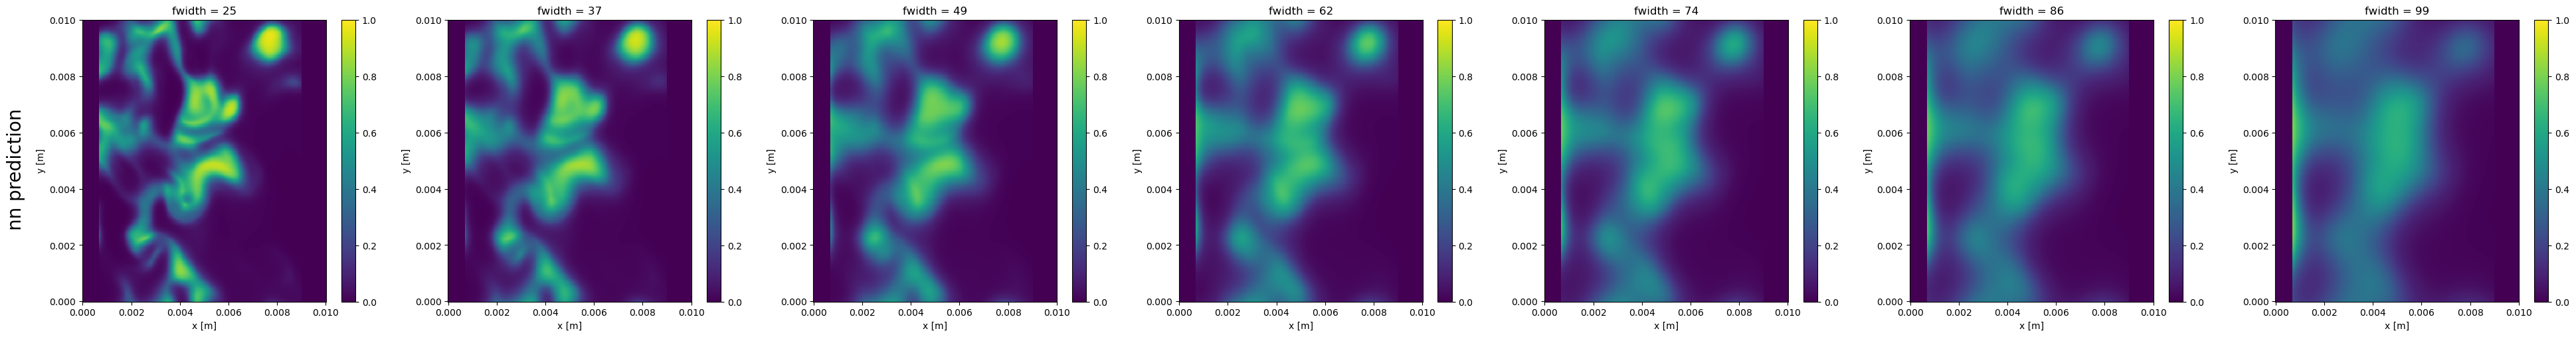

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)
x = np.arange(0, lx + dx, dx)
y = np.arange(0, ly + dy, dy)

# library
import numpy as np
import matplotlib.pyplot as plt
import scipy
from keras.models import load_model

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01 #[m]
dx, dy = lx/(nx-1), ly/(ny-1)
x = np.arange(0,lx+dx,dx)
y = np.arange(0,ly+dy,dy)

# flame related constants
TU = 1500.000 # K
TB = 1623.47 # K
DTH = 0.0012904903 # m
DU = 0.2219636 # kg/m^3
SL = 1.6585735551 # m/s

# normalization
CT_NORM = TB - TU
WCT_NORM = DU * SL / DTH
NCT_NORM = 1.0 / DTH

# function to load pre-filtered data based on fwidth from the filename
def bar(fwidth):
    filename = f"rest_of_the_data/case_B1_slice_data/bar-wtemp-slice-B1-0000080000-0{int(fwidth)}.raw"  # adjust according to your naming pattern
    data = np.fromfile(filename, count=-1, dtype=np.float64).reshape(nx, ny)
    data[:27,:] = 0
    data[346:,:] = 0
    return data
def tilde(fwidth):
    filename = f"rest_of_the_data/case_B1_slice_data/tilde-nablatemp-slice-B1-0000080000-0{int(fwidth)}.raw"  # adjust according to your naming pattern
    data = np.fromfile(filename, count=-1, dtype=np.float64).reshape(nx, ny)
    data[:27,:] = 0
    data[346:,:] = 0
    return data

# flame related constants
fwidth_n = np.array([25, 37, 49, 62, 74, 86, 99])

# Create figure and subplots
plt.figure(figsize=(40, 5))

for i, fwidth in enumerate(fwidth_n):


    data_1 = bar(fwidth=fwidth_n[i])
    data_2 = tilde(fwidth=fwidth_n[i])

    #Filter size variable
    data_3 = np.zeros(np.shape(data_1))
    data_3[:,0] = 0.5 * DTH

    #non-dimensionalization
    data_1 = data_1 / CT_NORM / WCT_NORM
    data_2 = data_2 / CT_NORM / NCT_NORM
    data_3 = data_3 / (2.0 * DTH)

    # make X
    X = np.concatenate((data_1.reshape(-1,1), data_2.reshape(-1,1), data_3.reshape(-1,1)), axis=1)

    # model load
    model = load_model('phi_nn_converted_model')

    # prediction
    phi_nn = np.zeros((np.shape(X)[0]))
    phi_nn = model.predict(X, batch_size=16, verbose=2).reshape(nx, ny)

    # data plot
    plt.subplot(1, 7, i + 1)
    mesh = plt.pcolor(x, y, np.moveaxis(phi_nn, (0, 1), (1, 0)),
                      cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(mesh)
    plt.title(f"fwidth = {fwidth}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")


plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
plt.figtext(0.015, 0.5, "nn prediction", va='center', ha='center', rotation='vertical', fontsize=20)
plt.savefig("nn-prediction.png", dpi=300)
plt.show()


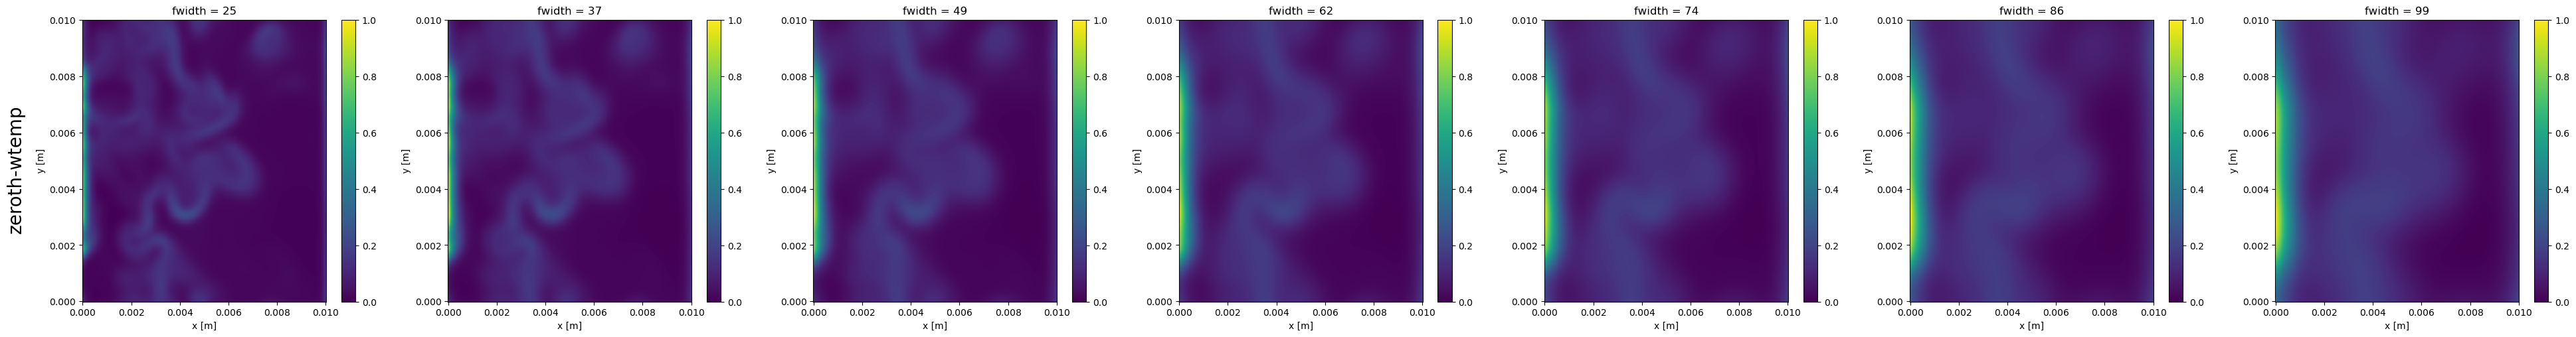

In [4]:
# library
import numpy as np
import matplotlib.pyplot as plt
import scipy


# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)
x = np.arange(0, lx + dx, dx)
y = np.arange(0, ly + dy, dy)



def load_filtered_data(fwidth):
    filename = f"rest_of_the_data/case_B1_slice_data/zeroth-wtemp-slice-B1-0000080000-0{int(fwidth)}.raw"  # adjust according to your naming pattern
    data = np.fromfile(filename, count=-1, dtype=np.float64).reshape(nx, ny)
    return data

# flame related constants
fwidth_n = np.array([25, 37, 49, 62, 74, 86, 99])

# Create figure and subplots
plt.figure(figsize=(40, 5))

for i, fwidth in enumerate(fwidth_n):
    # Load the pre-filtered data
    data_norm = load_filtered_data(fwidth)
    
    # Normalize to [0, 1] (if normalization is required)
    global_min, global_max = np.min(data_norm), np.max(data_norm)
    #global_min, global_max = 16471.735700120793, 284616.82635290886
    
    
    data_norm = (data_norm - global_min) / (global_max - global_min)
    
    # Plot the data
    plt.subplot(1, 7, i + 1)
    mesh = plt.pcolor(x, y, np.moveaxis(data_norm, (0, 1), (1, 0)),
                      cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(mesh)
    plt.title(f"fwidth = {fwidth}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
plt.figtext(0.015, 0.5, "zeroth-wtemp", va='center', ha='center', rotation='vertical', fontsize=20)
plt.savefig("DNS-data-ideal-les.png", dpi=300)
plt.show()


In [9]:
from PIL import Image

def merge_images_vertically(image_paths, output_path):
    if len(image_paths) != 2:
        raise ValueError("Exactly 3 image paths must be provided.")

    # Open all three images
    images = [Image.open(path) for path in image_paths]

    # Check that all images are the same size
    widths, heights = zip(*(img.size for img in images))
    if len(set(widths)) > 1 or len(set(heights)) > 1:
        raise ValueError("All images must have the same dimensions.")

    # Calculate new image size
    total_height = sum(heights)
    max_width = widths[0]

    # Create a new blank image
    merged_image = Image.new("RGB", (max_width, total_height))

    # Paste each image below the previous one
    y_offset = 0
    for img in images:
        merged_image.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the result
    merged_image.save(output_path)
    print(f"Merged image saved to {output_path}")

# Example usage:
if __name__ == "__main__":
    paths = ["les-data-nn-input-not-ideal.png", "nn-prediction.png"]
    merge_images_vertically(paths, "merged_output.jpg")


Merged image saved to merged_output.jpg


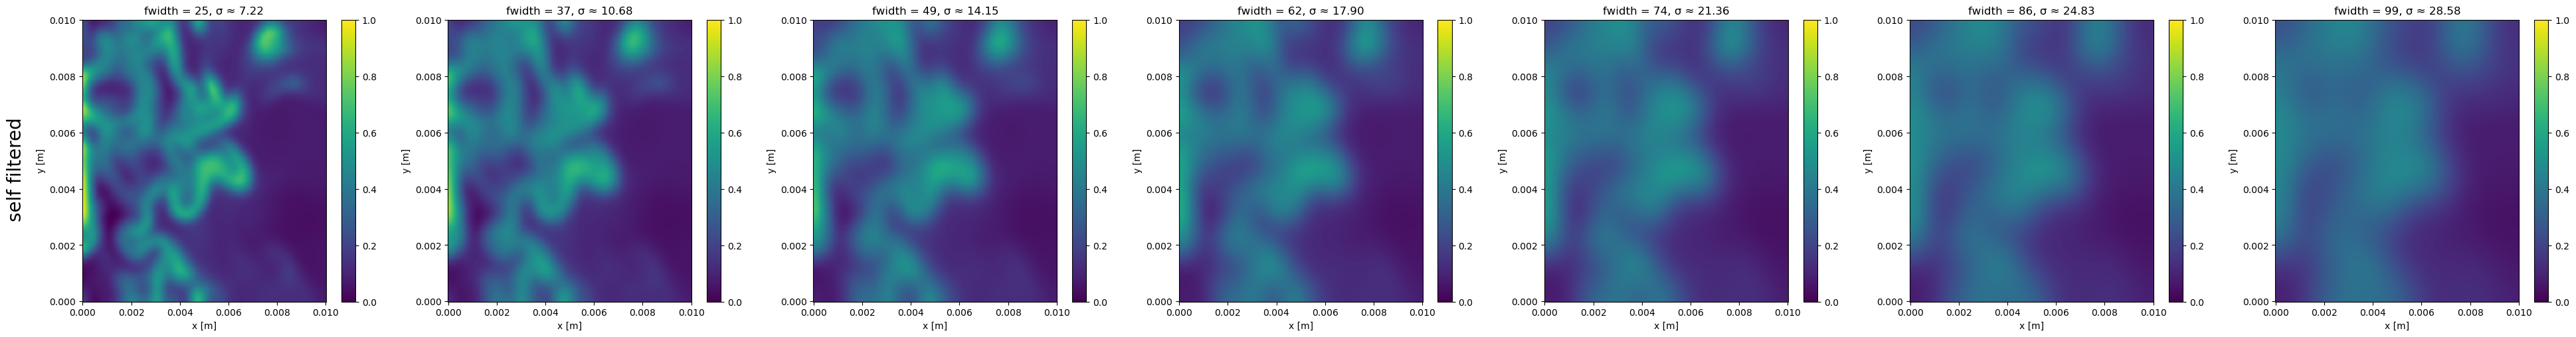

In [6]:
# MANUAL GAUDIAN FILTER

import numpy as np
import matplotlib.pyplot as plt
import scipy
from gauss import gaus

# spatial constants
nx, ny = 384, 384
lx, ly = 0.01, 0.01  # [m]
dx, dy = lx / (nx - 1), ly / (ny - 1)
x = np.arange(0, lx + dx, dx)
y = np.arange(0, ly + dy, dy)

# flame related constants
fwidth_n = np.array([25, 37, 49, 62, 74, 86, 99])

# load raw data
data_path = "wtemp-slice-B1-0000080000.raw"
data_orig = np.fromfile(data_path, count=-1, dtype=np.float64).reshape(nx, ny)

# Pre-filter all datasets and normalize globally
filtered_normalized = []
global_min, global_max = np.inf, -np.inf

# First pass: compute all filtered data and track global min/max
for fwidth in fwidth_n:
    data_filtered = gaus(fwidth, data_orig)
    global_min = min(global_min, np.min(data_filtered))
    global_max = max(global_max, np.max(data_filtered))
    filtered_normalized.append(data_filtered)

# Normalize to [0, 1]
filtered_normalized = [(d - global_min) / (global_max - global_min) for d in filtered_normalized]

# Create figure and subplots
plt.figure(figsize=(40, 5))

for i, (fwidth, data_norm) in enumerate(zip(fwidth_n, filtered_normalized)):
    sigma = fwidth / np.sqrt(12.0)
    
    plt.subplot(1, 7, i + 1)
    mesh = plt.pcolor(x, y, np.moveaxis(data_norm, (0, 1), (1, 0)),
                      cmap='viridis', vmin=0, vmax=1, shading='auto')
    plt.colorbar(mesh)
    plt.title(f"fwidth = {fwidth}, σ ≈ {sigma:.2f}")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")

plt.subplots_adjust(left=0.04, right=0.98, top=0.95, bottom=0.1)
plt.figtext(0.015, 0.5, "self filtered", va='center', ha='center', rotation='vertical', fontsize=20)
plt.savefig("self-filtered.png", dpi=300)
plt.show()

